In [2]:
import numpy as np
from scipy.io import loadmat
import pylab
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.style
import matplotlib as mpl
from matplotlib import rc
from IPython.display import HTML
from __future__ import print_function
from scipy.optimize import curve_fit
import scipy.integrate as integr

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)

# mpl.style.use('classic')
# # font = {'weight': 'bold',
# #         'size': 16}
# # rc('font', **font)
# axes = {'labelsize': 'large',
#        'facecolor': 'white'}
# figure = {'facecolor': 'white'}
# rc('figure', **figure)
# rc('axes', **axes)
# rc('lines', linewidth=2)
# rc('animation', html='html5')

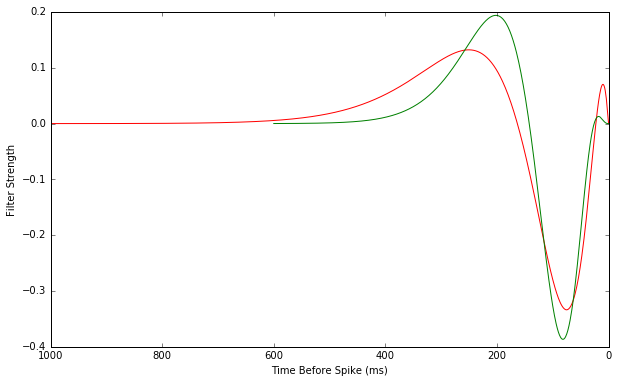

In [3]:
## preselected parameters for biphasic time course of a bipolar cell
delay = 33
# data = loadmat('argc_data.mat')
data = loadmat('param_filt.mat')
filt_transient = data['filt_T'][0]
filt_sustained = data['filt_S'][0]
filt_delayed = np.concatenate((np.zeros(delay), filt_transient[:-delay]))

## different dynamics for different bipolar cell types
filt_center = filt_transient
filt_surround = filt_sustained
plt.plot(filt_surround, 'r')
plt.plot(filt_center, 'g')
plt.gca().invert_xaxis()
plt.xlabel('Time Before Spike (ms)')
plt.ylabel('Filter Strength')
plt.savefig('filters_delay.png')

# definitions

In [58]:
def gaussian(sigma, gridx, gridy):
    g = np.exp(-( (gridx**2 + gridy**2) / (2.0 * sigma**2) ) )
    return g

def plot_response(center, surround, total=None, ls=''):
    plt.plot(center, 'g'+ls)
    plt.plot(surround, 'r'+ls)
    if total is not None:
        plt.plot(total, 'k'+ls)

class LS():
    def __init__(self, b, sigma_center, sigma_surround, filt_center, filt_surround, rflim=30):
        gridx, gridy = np.meshgrid(np.linspace(-rflim, rflim, rflim*2), np.linspace(-rflim, rflim, rflim*2))
        self.g_center = b * gaussian(sigma_center, gridx, gridy)
        self.g_surround = (1-b) * gaussian(sigma_surround, gridx, gridy)
        self.filt_center = filt_center
        self.filt_surround = filt_surround
        self.thresh_center = 0
        self.thresh_surround = 0 
        self.thresh_output = 0
        
    def linear_filter(self, filt_space, filt_time, thresh, stim):
        spatial_output = np.multiply(np.expand_dims(filt_space, 2), stim)
        spatial_output = np.mean(np.mean(spatial_output, axis=0), axis=0)
        temporal_output = conv(spatial_output, filt_time)
        threshold_output = np.maximum(temporal_output-thresh, 0)
        return spatial_output, temporal_output, threshold_output
    
    def model_response(self, stim):
        c_space, c_time, c_out = self.linear_filter(self.g_center, self.filt_center, self.thresh_center, stim)
        s_space, s_time, s_out = self.linear_filter(self.g_surround, self.filt_surround, self.thresh_surround, stim)
        out = np.maximum(c_out-s_out - self.thresh_output, 0)
        self.c_space, self.c_time, self.c_out, self.s_space, self.s_time, self.s_out, self.out = c_space, c_time, c_out, s_space, s_time, s_out, out
    
    def plot_components(self):
        plt.figure()
        ax1 = plt.gca()
        plot_response(self.c_space, self.s_space, ls='--')
        plt.ylabel('Light Intensity')
        ax2 = ax1.twinx()
        plt.ylabel('Output')
        plot_response(self.c_out, self.s_out, self.out, ls='')
        plt.xlim([0, T])
        plt.xlabel('Time (ms)')
        
    def plot_stages(self):
        plt.figure()
        plt.subplot(1, 3, 1)
        plot_response(self.c_space, self.s_space, ls='--')
        plt.title('Spatial Averaging')

        plt.subplot(1, 3, 2)
        plot_response(self.c_time, self.s_time, ls='')
        plt.title('Temporal Filtering')

        plt.subplot(1, 3, 3)
        plot_response(self.c_out, self.s_out, total=self.out, ls='')
        plt.title('Nonlinearity')
        
    def survey_responses(self, visible=False):
        for i in range(10):
            plt.subplot(2, 5, i+1)
            stim = select_stim(stims[i])

            # output from stimulus
            self.model_response(stim)

            # plot on same subplot
            plot_response(self.c_out, self.s_out, total=self.out, ls='')
            plt.xlim([0, np.shape(stim)[2]])
            plt.title(titles[i])
            
            if i+1 == 6:
                plt.legend(['Center', 'Surround', 'Total'])
                plt.xlabel('Time (ms)')
                plt.ylabel('Firing Rate')
                if not visible:
                    plt.gca().tick_params(axis='y',labelleft='off')
            else:
                if not visible:
                    plt.gca().tick_params(axis='x',labelbottom='off')
                    plt.gca().tick_params(axis='y',labelleft='off')
    
    def plot_rf(self):
#         ## cross section of spatial receptive field
#         plt.figure()
#         plt.plot(self.g_center[vflim/2, :], 'g')
#         plt.plot(-self.g_surround[vflim/2, :], 'r')

        ## heat map of spatial receptive field
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.imshow(self.g_center, vmin=0, cmap='gray', interpolation='none')
        # plt.title('Center')
        plt.axis('off')
        plt.subplot(2, 1, 2)
        plt.imshow(-self.g_surround, vmax=0, cmap='gray', interpolation='none')
        # plt.title('Surround')
        plt.xticks([])
        plt.yticks([])
        
    ## add suppressing synapse
    def calc_w(self, tau, a, wmin=0):
        T = np.size(self.out)
        w = np.ones(T+1)
        g = self.out
        for t in range(T):
            dwdt = (1-w[t])/tau - a*g[t]*(w[t]-wmin)
            w[t+1] = w[t]+dwdt
        self.w = w[1:]
        self.postsynaptic = self.w*self.out
        
    def plot_suppression(self, start_times=None, duration=None):
        plt.subplot(3, 1, 1)
        plt.plot(self.out, 'k')
        plt.xticks([])
        plt.ylabel('Firing Rate')
        ax = plt.gca()
        if start_times is not None:
            draw_patch(ax, start_times, duration, color='r', alpha=0.1)
        ax.tick_params(axis='y',labelleft='off')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        plt.subplot(3, 1, 2)
        plt.plot(self.w, 'g')
        ax = plt.gca()
        plt.xticks([])
        plt.ylim([0, 1])
        plt.ylabel('Synaptic Strength')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        plt.subplot(3, 1, 3)
        plt.plot(self.postsynaptic, 'k')
        plt.ylabel('Postsynaptic Effect')
        plt.xlabel('Time (ms)')
        ax = plt.gca()
        if start_times is not None:
            draw_patch(ax, start_times, duration, color='r', alpha=0.1)
        ax.tick_params(axis='y',labelleft='off')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    def calc_isirecovery(self, start_times):
        peak = []
        for t in start_times.astype(int):
            peak.append(max(self.postsynaptic[t:t+1000]))
        return peak/peak[0]

In [4]:
K = 5

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = [i*K, i*K]
    y = [0, 1]
    line.set_data(x, y)
    return (line,)

def animate_stim(stim):
    fig = plt.figure()
    ims = []
    T = np.shape(stim)[2]
    for i in range(0, T, K):
#         im = plt.imshow(stim[:, :, i], cmap='gray', interpolation='none', vmin=-1, vmax=1, animated=True)
        im = plt.imshow(stim[:, :, i], cmap='gray', interpolation='none', vmin=-1, vmax=1)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    HTML(ani.to_html5_video())
    return ani

def disp(img):
    plt.imshow(img, cmap='gray', interpolation='none', vmin=-1, vmax=1, origin='lower')

def conv(arr0, arr1):
    arr0 = np.flip(np.append(np.flip(arr0, axis=0), np.zeros(len(arr1)-1)), axis=0)
    output = np.convolve(arr0, arr1, mode='valid')
    return output

def gray(T):
    stim = np.zeros((intervals, intervals, T))
    return stim

def circle(r, mu=(0,0)):
    stim = np.zeros_like(x)
    for i in range(intervals):
        for j in range(intervals):
            if (x[i, j]-mu[0])**2 + (y[i, j]-mu[1])**2 <= r**2:
                stim[i, j] = -1
    return stim

def moving_spot(r, T, micronspersec, start=None):
    if start is None:
        start = 0
    mu_y = 0
    mu_x = -vflim-r
    increment = float(micronspersec)/1000
    stim = np.zeros((intervals, intervals, T))
    for i in range(T):
        if start+i == T:
            break
        stim[:, :, start+i] = circle(r, (mu_x+increment*i, mu_y))
    return stim

def flashed_spot(r, T, start=None, duration=None):
    if start is None:
        start = T/4
    if duration is None:
        duration = T/2
    stim = np.zeros((intervals, intervals, T))
    stim[:, :, start:start+duration] = np.repeat(np.expand_dims(circle(r), 2), duration, axis=2)
    return stim

def dimming_spot(r, T, start=None, duration=None):
    if start is None:
        start = T/4
    if duration is None:
        duration = T/2
    stim = flashed_spot(r, T, start, duration)
    gradient = np.zeros((1, 1, T))
    gradient[0, 0, start:start+duration] = np.linspace(0, 1, duration)
    stim = np.multiply(stim, gradient)
    return stim

def receding_spot(r, T, duration, pause_duration=None, start=None):
    if start is None:
        start = 0
    if pause_duration is None:
        pause_duration = 0
    stim = np.zeros((intervals, intervals, T))
    radii = np.flip(np.linspace(0, r, duration), axis=0)
    stim[:, :, start:start+pause_duration] = np.repeat(np.expand_dims(circle(r), 2), pause_duration, axis=2)
    for i in range(duration):
        z = radii[i]
        stim[:, :, start+pause_duration+i] = circle(z)
    return stim

def expanding_spot(r, T, duration, pause_duration=None, start=None, mu=(0, 0)):
    if start is None:
        start = 0
    if pause_duration is None:
        pause_duration = 0
    stim = np.zeros((intervals, intervals, T))
    radii = np.linspace(0, r, duration)
    for i in range(duration):
        z = radii[i]
        stim[:, :, start+i] = circle(z, mu)
    stim[:, :, start+duration:start+duration+pause_duration] = np.repeat(np.expand_dims(circle(r, mu), 2), pause_duration, axis=2)
    return stim

def concat_stim(stim_list):
    stim = stim_list[0]
    for i in range(1, len(stim_list)):
        stim = np.append(stim, stim_list[i], axis=2)
    return stim
    
def even_axes(fig, ymax=None):
    subplots = fig.get_axes()
    if ymax is None:
        vals = []
        for sp in subplots:
            ylim = sp.get_ylim()
            vals.append(ylim[1])
        ymax = max(vals)
    for sp in subplots:
        sp.set_ylim([0, ymax])

def select_stim(stim_type):
    if stim_type == 'expanding_centered':
        stim = stim_expanding_centered
    elif stim_type == 'expanding_displaced':
        stim = stim_expanding_displaced 
    elif stim_type == 'receding':
        stim = stim_receding
    elif stim_type == 'translating':
        stim = stim_translating
    elif stim_type == 'dimming':
        stim = stim_dimming
    elif stim_type == 'flashed0':
        stim = stim_flashed_0
    elif stim_type == 'flashed1':
        stim = stim_flashed_1
    elif stim_type == 'flashed2':
        stim = stim_flashed_2
    elif stim_type == 'flashed3':
        stim = stim_flashed_3
    elif stim_type == 'flashed4':
        stim = stim_flashed_4
    return stim

def extract_rf(center, stim, rflim):
    S = np.shape(stim)[0]
    x = S/2 + center[1]
    y = S/2 + center[0]

    xmin = x-rflim
    xmax = x+rflim
    ymin = y-rflim
    ymax = y+rflim

    pad_south, pad_north, pad_west, pad_east = 0, 0, 0, 0
    
    if xmax > S:
        pad_north = xmax-S
        xmax = S
    if xmin < 0:
        pad_south = -xmin
        xmin = 0
    if ymax > S:
        pad_east = ymax-S
        ymax = S
    if ymin < 0:
        pad_west = -ymin
        ymin = 0

    stim_local = stim[xmin:xmax, ymin:ymax]
    T = np.shape(stim)[2]

    stim_local = stim_local
    if pad_south > 0:
        pad = np.zeros((pad_south, np.shape(stim_local)[1], T))
        stim_local = np.append(pad, stim_local, axis=0)
    if pad_north > 0:
        pad = np.zeros((pad_north, np.shape(stim_local)[1], T))
        stim_local = np.append(stim_local, pad, axis=0)
    if pad_west > 0:
        pad = np.zeros((np.shape(stim_local)[0], pad_west, T))
        stim_local = np.append(pad, stim_local, axis=1)
    if pad_east > 0:
        pad = np.zeros((np.shape(stim_local)[0], pad_east, T))
        stim_local = np.append(stim_local, pad, axis=1)
    
    return stim_local, x, y, xmin, xmax, ymin, ymax

def draw_rect(x, y, xmin, xmax, ymin, ymax):
    plt.plot([100, 100], [0, 200], 'b')
    plt.plot([0, 200], [100, 100], 'b')
    
    plt.plot([ymin, ymin], [xmin, xmax], 'r')
    plt.plot([ymax, ymax], [xmin, xmax], 'r')
    plt.plot([ymin, ymax], [xmin, xmin], 'r')
    plt.plot([ymin, ymax], [xmax, xmax], 'r')
    plt.plot(y, x, 'ro')

def draw_patch(ax, start_times, duration, color='b', alpha=0.2):
    for t in start_times:
        rect = plt.Rectangle([t, 0], duration, 1, alpha=alpha, color=color)
        ax.add_artist(rect)

def draw_circle(ax, mu, r, color='b'):
    circle = plt.Circle(mu, r, color=color, fill=False)
    ax.add_artist(circle)
    
def loom_locations(params):
    order = {}
    stim = []
    for pair in params:
        for n in pair[1]:
            order[n] = pair[0]
    for n in range(max(order.keys())+1):
        stim.append(order[n])
    stim = concat_stim(stim)
    return stim

def plot_isirecovery(start_times, y, ls='ro--'):
    x = start_times/1000
    plt.plot(x, y, ls)
    plt.ylim([0, 1])
    plt.gca().set_xscale('log')
    plt.gca().set_xscale('log')
    plt.ylabel('% suppression')
    plt.xlabel('inter-trial interval (s)')

# stimulus types

In [5]:
vflim = 50
intervals = 2*vflim
x, y = np.meshgrid(np.linspace(-vflim, vflim, vflim*2), np.linspace(-vflim, vflim, vflim*2))

T = 1000
r = 15
micronspersec = 60
radii = [1.5, 4, 7.5, 15, 35]

stim_expanding_centered = expanding_spot(r, T, 500, pause_duration=250, start=250, mu=(0, 0))
stim_expanding_displaced = expanding_spot(r, T, 500, pause_duration=250, start=250, mu=(10, 10))
stim_receding = -receding_spot(r, T, 500, pause_duration=250, start=250)
stim_translating = moving_spot(r, T, micronspersec, start=0)
stim_dimming = dimming_spot(r, T)
stim_flashed_0 = flashed_spot(radii[0], T, start=None, duration=None)
stim_flashed_1 = flashed_spot(radii[1], T, start=None, duration=None)
stim_flashed_2 = flashed_spot(radii[2], T, start=None, duration=None)
stim_flashed_3 = flashed_spot(radii[3], T, start=None, duration=None)
stim_flashed_4 = flashed_spot(radii[4], T, start=None, duration=None)

stims = ['expanding_centered',
        'expanding_displaced', 
        'receding',
        'translating',
        'dimming',
        'flashed0',
        'flashed1',
        'flashed2', 
        'flashed3',
        'flashed4']

titles = ['Loom Centered',
        'Loom Displaced',
        'Receding White',
        'Translating',
        'Dimming',
        'Flashed Spot: '+str(radii[0]*2)+ '$^\circ$',
        'Flashed Spot: '+str(radii[1]*2)+ '$^\circ$',
        'Flashed Spot: '+str(radii[2]*2)+ '$^\circ$',
        'Flashed Spot: '+str(radii[3]*2)+ '$^\circ$',
        'Flashed Spot: '+str(radii[4]*2)+ '$^\circ$']

# single stimulus type

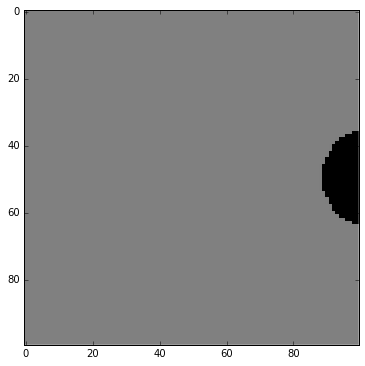

In [12]:
## video of stimulus
stim_type = 'translating'
stim = select_stim(stim_type)
# animate_stim(stim)
ani = animate_stim(stim)
ani.save(stim_type+'.mp4')

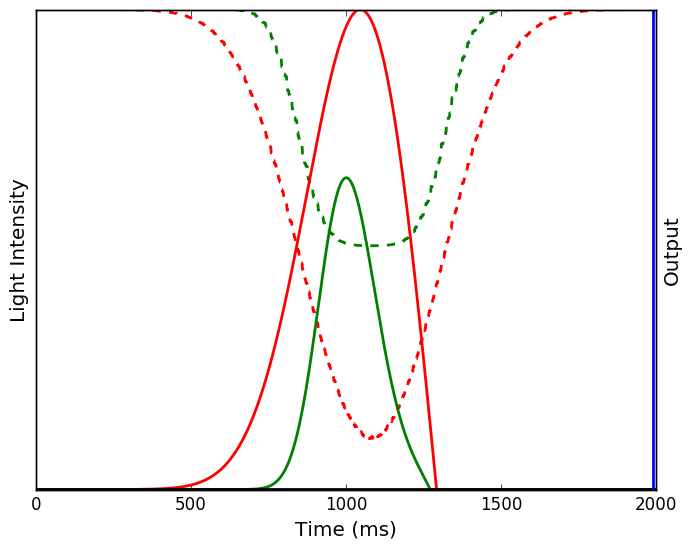

In [14]:
## model a cell's response to stimulus
neuron = LS(0.7, 4, 10, filt_center, filt_surround, rflim=50)
neuron.model_response(stim)

## video of cell's response to stimulus (dashed and solid)
fig = plt.figure()
plt.xlabel('Time (ms)')

ax1 = plt.gca()
plt.ylabel('Light Intensity')
plot_response(neuron.c_space, neuron.s_space, ls='--')
plt.yticks([])

ax2 = ax1.twinx()
plt.ylabel('Output')
plot_response(neuron.c_out, neuron.s_out, neuron.out, ls='')
plt.yticks([])

line, = ax2.plot([], [], 'b', lw=2)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=T/K, interval=50, blit=True, repeat_delay=1000)
HTML(ani.to_html5_video())
ani.save(stim_type+'_prediction.mp4')

In [ ]:
## video of cell's response to stimulus (solid)
fig, ax = plt.subplots()
ax.set_xlim((0, T))
plot_response(neuron.c_out, neuron.s_out, neuron.out)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Firing Rate')
ax.tick_params(axis='y',labelleft='off')
line, = ax.plot([], [], 'b', lw=2)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=T/K, interval=50, blit=True, repeat_delay=1000)
HTML(ani.to_html5_video())
ani.save(stim_type+'_prediction.mp4')

In [ ]:
## figures of model parts
neuron.plot_components()
plt.savefig(stim_type+'_prediction.png')
# neuron.plot_stages()

# survey of responses to stimulus types

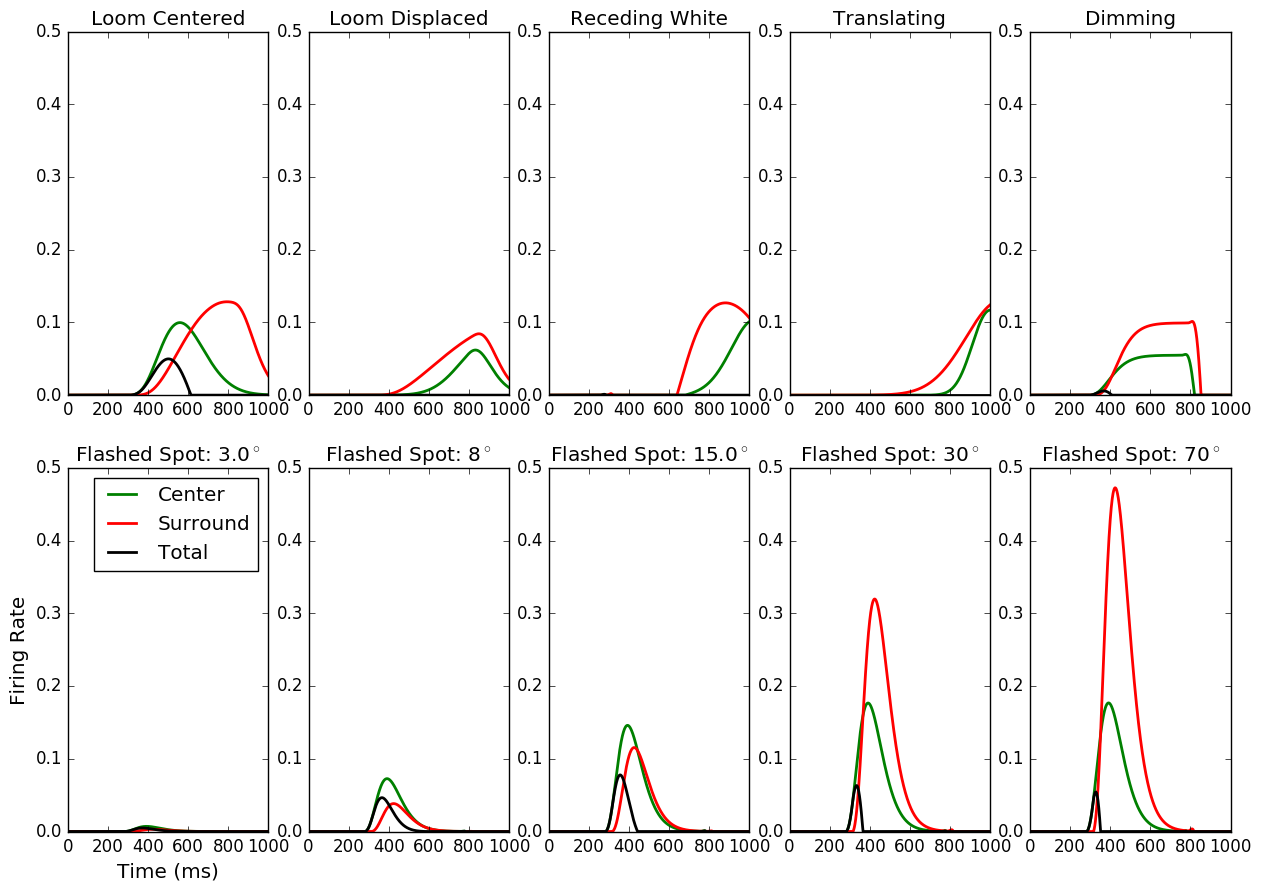

In [31]:
## survey of responses: single parameter setting
fig = plt.figure(figsize= (15,10))
neuron = LS(0.7, 4, 10, filt_center, filt_delayed, rflim=50)
# neuron.thresh_output = 0.04
neuron.survey_responses(visible=True)
even_axes(fig)
# plt.savefig('survey_delayed.png')

In [ ]:
## survey of responses: loop over parameter settings
sigma_center = range(2, 6)
sigma_surround = range(10, 14)
ratio = [0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(len(sigma_center)):
    for j in range(len(sigma_surround)):
        for k in range(len(ratio)):
            neuron = LS(ratio[k], sigma_center[i], sigma_surround[j], filt_center, filt_surround)
            fig = plt.figure(figsize= (15,10))
            neuron.survey_responses()
            even_axes(fig)
            plt.savefig('survey'+'_'+str(sigma_center[i])+'_'+str(sigma_surround[j])+'_'+str(a)+'.png')
            plt.close()

# add familiarity suppression

In [64]:
## cell's response to single loom
vflim = 30
intervals = 2*vflim
x, y = np.meshgrid(np.linspace(-vflim, vflim, vflim*2), np.linspace(-vflim, vflim, vflim*2))

T = 1000
r = 15
mu = (0, 0)
stim = expanding_spot(r, T, 500, pause_duration=250, start=250, mu=mu)

neuron = LS(0.8, 4, 10, filt_center, filt_surround)

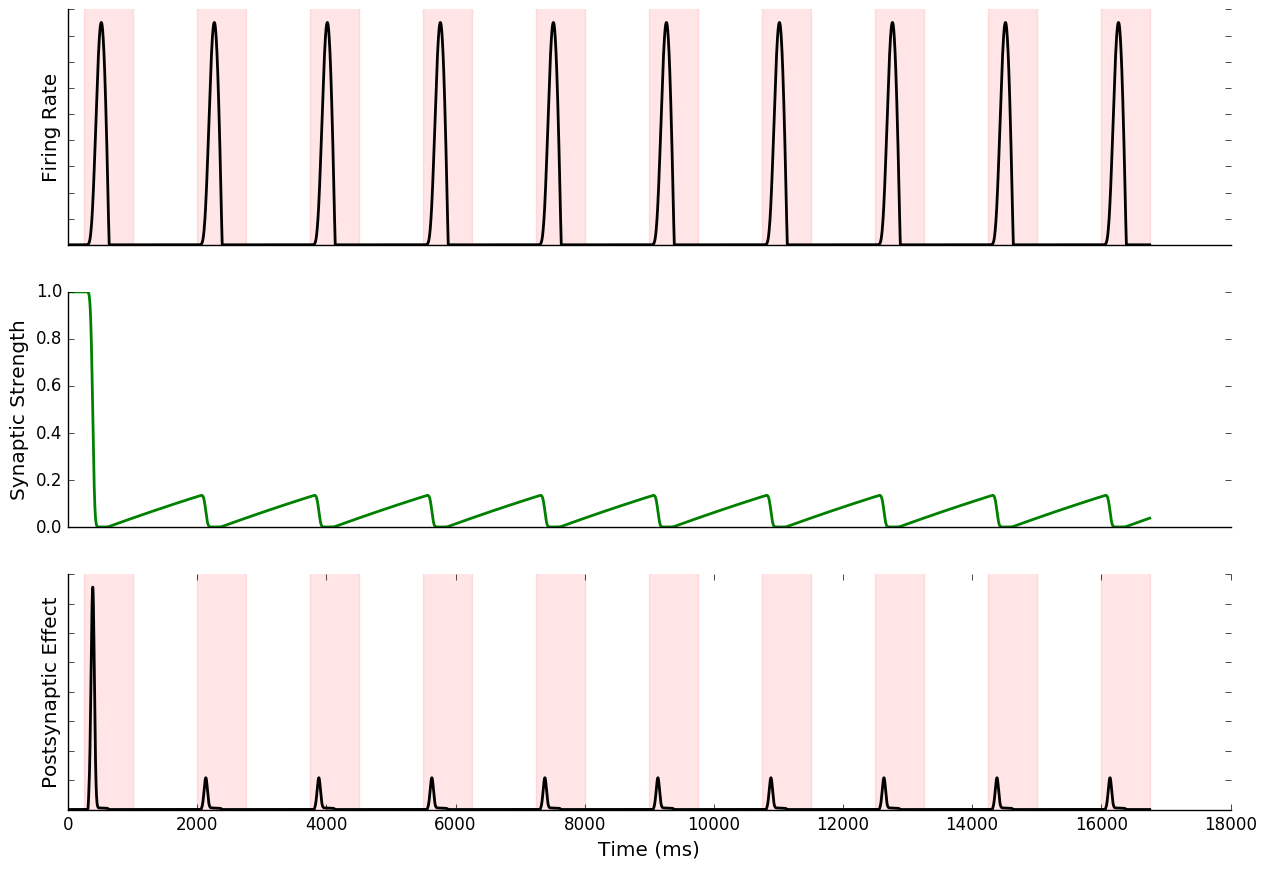

In [61]:
## cell's response to 10 looms with 1 second ISI
neuron.model_response(stim)
out = neuron.out
g = np.concatenate((out, np.zeros(750), out, np.zeros(750), out, np.zeros(750), out, np.zeros(750), out, np.zeros(750), 
                     out, np.zeros(750), out, np.zeros(750), out, np.zeros(750), out, np.zeros(750), out))

tau = 10000
a = 1
wmin = 0

neuron.out = g
neuron.calc_w(tau, a, wmin)

start_times = 250 + 1.75*np.arange(10)*1000
duration=750
fig = plt.figure(figsize= (15,10))
neuron.plot_suppression(start_times, duration)
plt.savefig('FS_consecutive_long.png')

In [66]:
## cell's response to looms with varying ISI
neuron.model_response(stim)
out = neuron.out
g = np.concatenate((np.zeros(500), out, np.zeros(500), out, np.zeros(1000), out, np.zeros(5000), out,
                     np.zeros(10000), out, np.zeros(20000), out, np.zeros(60000), out, np.zeros(120000), out))
neuron.out = g
start_times = np.asarray([0.5, 2, 4, 10, 21, 42, 103, 224])*1000
duration = 750

In [79]:
## load data for response to multiple looms with varying ISI
ind = 36

folder = '/home/alvita/Dropbox (Vision Lab Cal Tech)/20170928_2/'
folder_loom = 'loom_170928_013221.rhd/'
folder_loomtime = 'loomtime_170928_010025.rhd/'
folder_exp = folder_loomtime
S = loadmat(folder+folder_exp+'spiketrain.mat')
stimdata = loadmat(folder+folder_exp+'stim.mat')
stimtrigger = stimdata['stim_trigger'][0]
cellid = S['cellid'][0]
spiketrain = S['spiketrain'][0]

counts, bins = np.histogram(spiketrain[ind], bins=stimtrigger)
spike_counts = [counts[i] for i in range(np.size(counts)) if np.mod(i, 2) == 0]
data = np.asarray(spike_counts) / float(spike_counts[0])

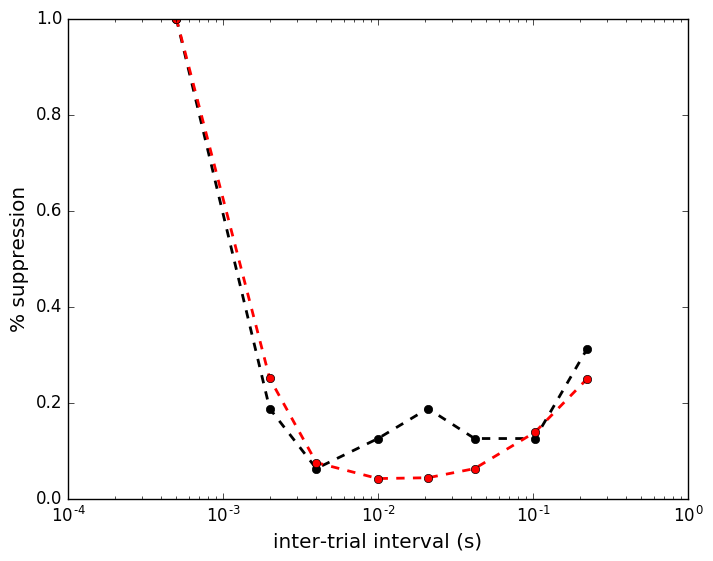

In [81]:
## single parameter setting
tau = 500000
a = 0.05
wmin = 0.01

neuron.calc_w(tau, a, wmin)

x = start_times/1000
y = neuron.calc_isirecovery(start_times)
plot_isirecovery(x, data, 'ko--')
plot_isirecovery(x, y, 'ro--')
plt.savefig(str(ind)+'.png')

In [ ]:
## loop over parameter settings
TAUS = [1000, 10000, 100000, 1000000]
AS = [.2, .5, .8]
wmin = 0.1

sp = 1
for i in range(np.size(TAUS)):
    for j in range(np.size(AS)):
        plt.subplot(np.size(TAUS), np.size(AS), sp)
        neuron.calc_w(TAUS[i], AS[j], wmin)
        
        x = start_times/1000
        y = neuron.calc_isirecovery(start_times)
        plot_isirecovery(x, data, 'bo--')
        plot_isirecovery(x, y, 'ro--')
        plt.title('R=%.2f' %np.corrcoef(y, data)[0, 1])
        
        sp += 1

# add invariance

In [107]:
def loom_locations(params):
    order = {}
    stim = []
    for info in params:
        for n in info[1]:
            order[n] = info[0]
    for n in range(max(order.keys())+1):
        stim.append(order[n])
        stim.append(gray(1000))
    stim = concat_stim(stim)
    return stim

In [108]:
## grid for larger visual field
vflim = 50
intervals = 2*vflim
x, y = np.meshgrid(np.linspace(-vflim, vflim, intervals), np.linspace(-vflim, vflim, intervals))

## concat multiple stimuli in larger receptive field
T = 1000
r = 15
micronspersec = 60

muA = (0, 0)
muB = (19, 19)
loomA = expanding_spot(r, T, 500, pause_duration=250, start=250, mu=muA)
loomB = expanding_spot(r, T, 500, pause_duration=250, start=250, mu=muB)
sequenceA = [0, 1, 3] 
sequenceB = [2, 4, 5] 

params = [[loomA, sequenceA, muA, 'r'], [loomB, sequenceB, muB, 'b']]
stim = loom_locations(params)

In [109]:
## parameters for loom sensitive neuron
b = 0.7
sigma_center = 4
sigma_surround = 10
filt_surround = np.minimum(filt_center, 0)

## parameters for familiarity suppression between loom sensitive and familiarity suppression neuron
tau = 10000
a = 1
wmin = 0

## grid for centers of interneurons
cells = 7
interneuronx, interneurony = np.meshgrid(np.linspace(-vflim, vflim, cells), np.linspace(-vflim, vflim, cells))

## pool over loom sensitive neurons
T = np.shape(stim)[2]
active_inds = []
active_neurons = []
rflim = 30
for i in range(cells**2):
    center = [int(interneuronx.flatten()[i]), int(interneurony.flatten()[i])]
    stim_local, xcenter, ycenter, xmin, xmax, ymin, ymax = extract_rf(center, stim, rflim)
    if np.any(stim_local):
        neuron = LS(b, sigma_center, sigma_surround, filt_center, filt_surround)
        neuron.center = center
        neuron.model_response(stim_local)
        if not np.isclose(np.max(neuron.out), 0):
            neuron.calc_w(tau, a, wmin)
            active_inds.append(i)
            active_neurons.append(neuron)

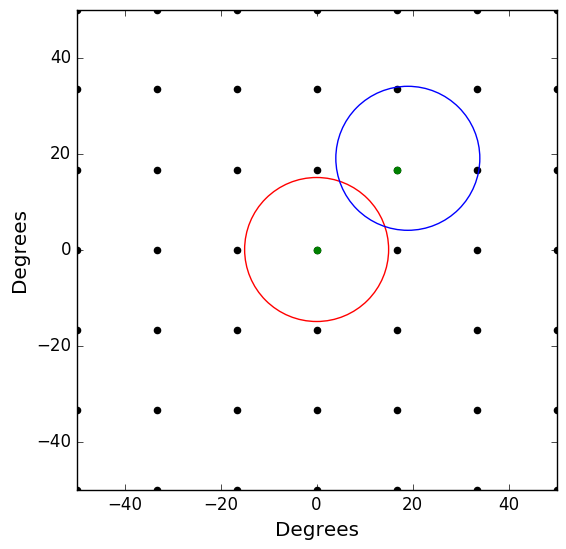

In [110]:
## experiment details
fig = plt.figure()
plt.xlim([-vflim, vflim])
plt.ylim([-vflim, vflim])
plt.gca().set_aspect('equal', adjustable='box')
ax = fig.gca()

for loom in params:
    draw_circle(ax, loom[2], r, color=loom[3])

plt.scatter(interneuronx.flatten(), interneurony.flatten(), color='k')
plt.scatter(interneuronx.flatten()[active_inds], interneurony.flatten()[active_inds], color='g')

plt.xlabel('Degrees')
plt.ylabel('Degrees')
plt.savefig('locations_loom_rf.png')

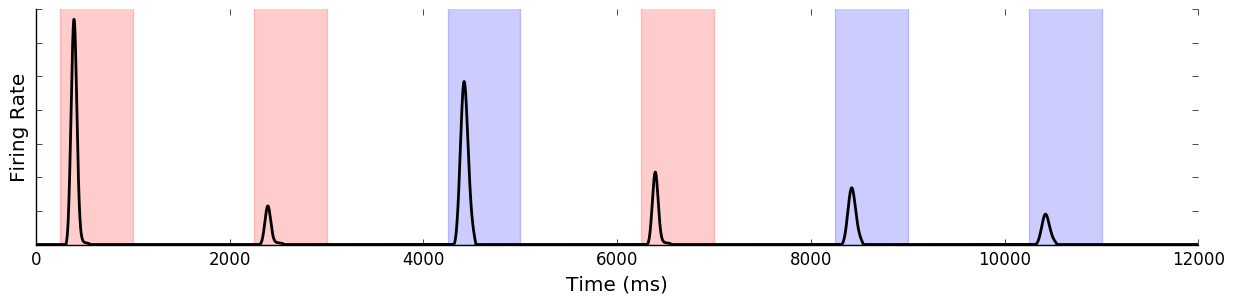

In [118]:
## prediction details for postsynaptic neuron
total = 0
for neuron in active_neurons:
    total += neuron.postsynaptic

fig = plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(total, 'k')
ax = fig.gca()
duration = 750

for loom in params:
    starttimes = np.asarray(loom[1])*2000 + 250
    draw_patch(ax, starttimes, duration, color=loom[3])
    
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(axis='y',labelleft='off')

plt.xlim((0, T))
plt.ylabel('Firing Rate')
plt.xlabel('Time (ms)')
plt.savefig('finalneuron.png')

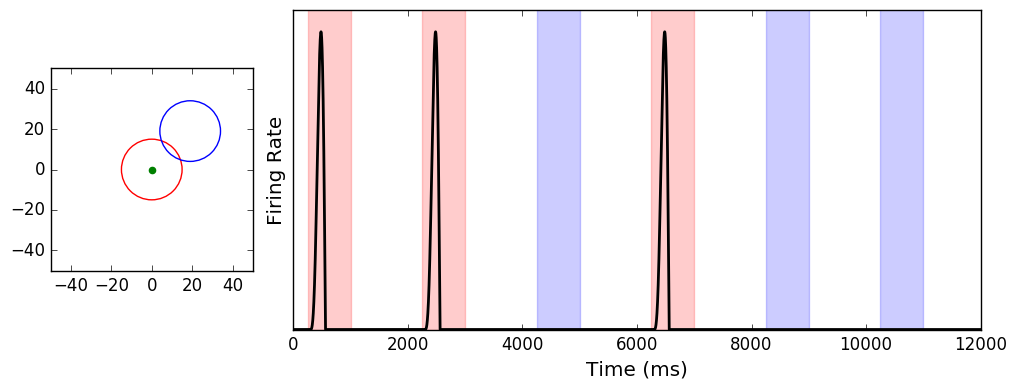

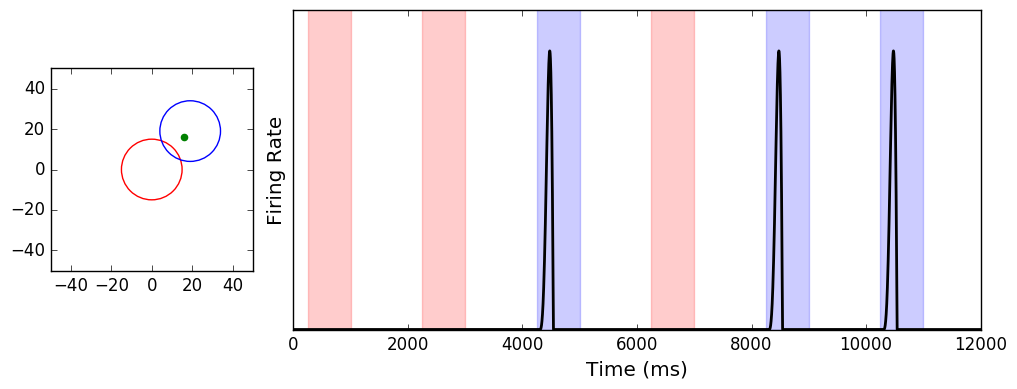

In [119]:
## prediction details for presynaptic neurons
i = 0
for neuron in active_neurons:
    fig = plt.figure(figsize= (12,4))
    
    plt.subplot2grid((1, 4), (0, 0)) 
    plt.xlim([-vflim, vflim])
    plt.ylim([-vflim, vflim])
    ax = fig.gca()
    ax.set_aspect('equal', adjustable='box')
    for loom in params:
        draw_circle(ax, loom[2], r, color=loom[3])
    plt.scatter(neuron.center[0], neuron.center[1], color='g')

    plt.subplot2grid((1, 4), (0, 1), colspan=3) 
    plt.plot(neuron.out, 'k')
    plt.yticks([])
    ax = fig.gca()
    for loom in params:
        starttimes = np.asarray(loom[1])*2000 + 250
        draw_patch(ax, starttimes, duration, color=loom[3])        
        
    plt.ylabel('Firing Rate')
    plt.xlabel('Time (ms)')

    plt.savefig(str(i)+'_interneuron_rf.png')
    i +=1

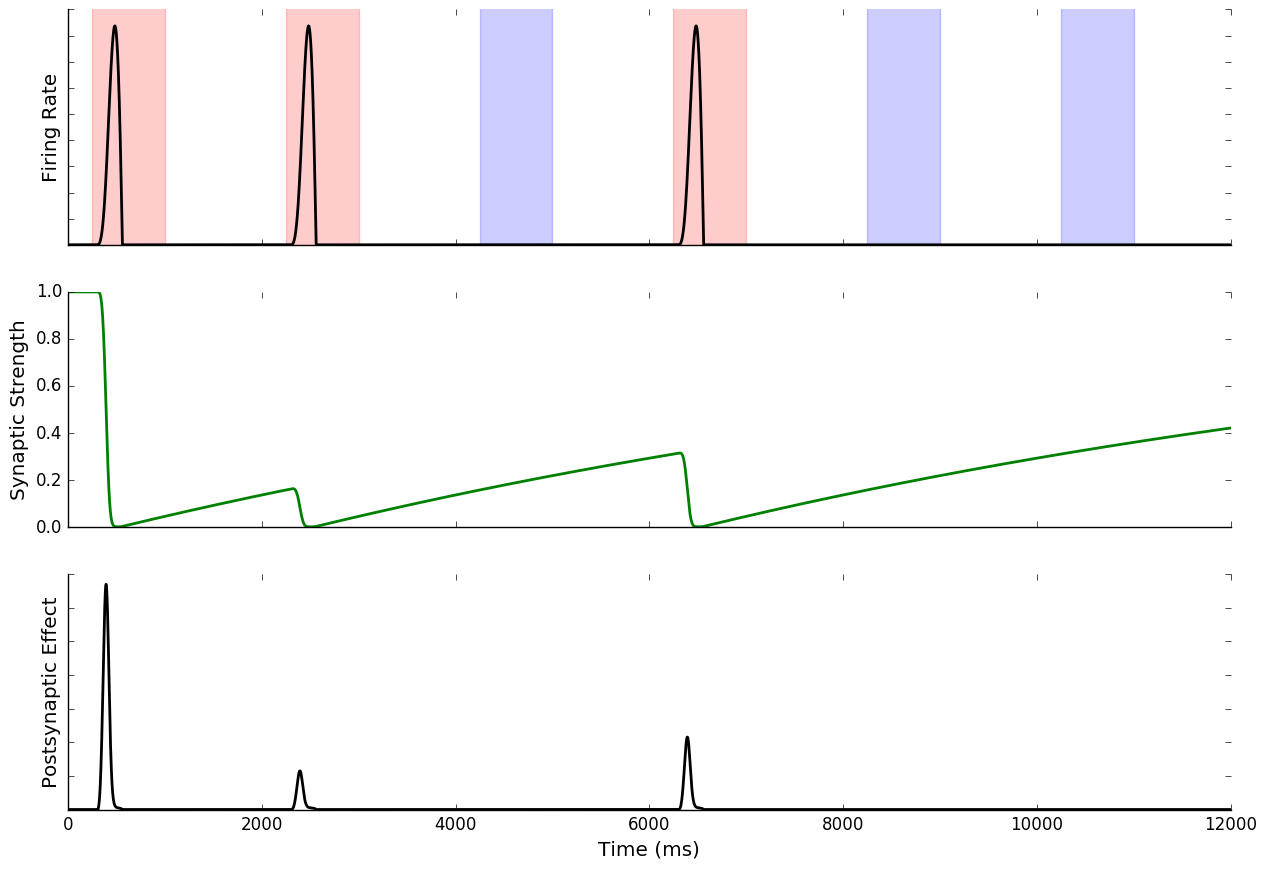

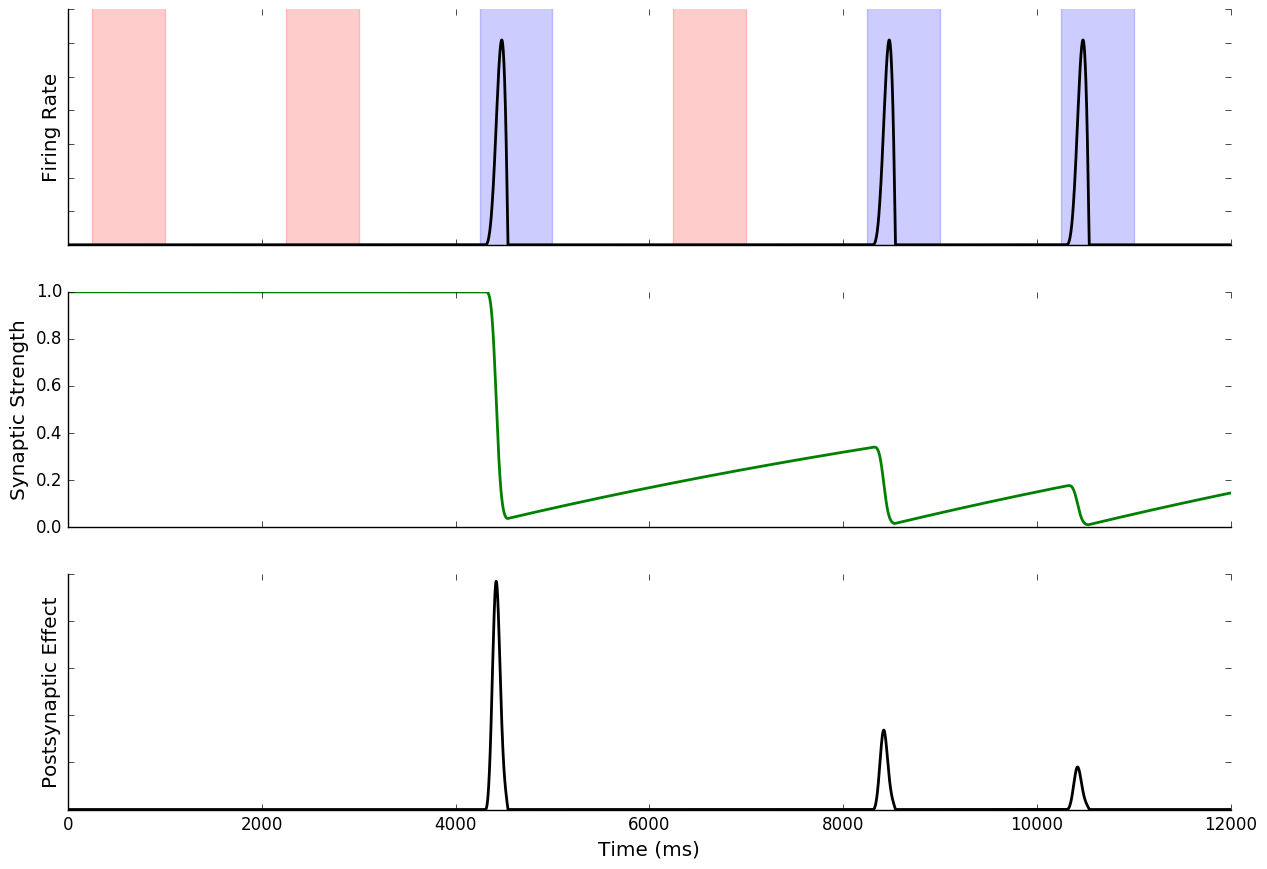

In [117]:
i = 0
for neuron in active_neurons:
    fig = plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(neuron.out, 'k')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylabel('Firing Rate')
    ax = fig.gca()
    for loom in params:
        starttimes = np.asarray(loom[1])*2000 + 250
        draw_patch(ax, starttimes, duration, color=loom[3])  
    plt.gca().tick_params(axis='y',labelleft='off')
    plt.gca().tick_params(axis='x',labelbottom='off')

    plt.subplot(3, 1, 2)
    plt.plot(neuron.w, 'g')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylabel('Synaptic Strength')
    plt.gca().tick_params(axis='x',labelbottom='off')

    plt.subplot(3, 1, 3)
    plt.plot(neuron.postsynaptic, 'k')
    plt.ylabel('Postsynaptic Effect')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().tick_params(axis='y',labelleft='off')
    plt.xlabel('Time (ms)')
    
    plt.savefig(str(i)+'_interneuron.png')
    i +=1